In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
import re
from scipy.interpolate import interp1d
import seaborn as sns
from true_params import true_params

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Our model is simple: a top-hat in $x$ from zero to 1, followed by a Gaussian falloff at 1 with a width of 0.1:
$$
\frac{\mathrm{d} N}{\mathrm{d} x} \propto \begin{cases}
0 & x < 0 \\
1 & 0 \leq x < 1 \\
\exp\left( - \frac{\left( x-1 \right)^2}{2 \left(0.1\right)^2}\right) & 1 \leq x
\end{cases}
$$

In [3]:
sigma_true = 0.1
mu_true = 1.0

def draw(size=1):
    flat_wt = 1.0
    gauss_wt = sqrt(pi/2)*sigma_true
    
    total_wt = flat_wt + gauss_wt
    
    rs = total_wt*rand(size)
    
    ng = count_nonzero(rs>1)
    if ng >= 1:
        gs = mu_true + abs(sigma_true*randn(ng))
        
    xs = zeros_like(rs)
    xs[rs<=1] = rs[rs<=1]
    if ng >= 1:
        xs[rs>1] = gs
    return xs

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


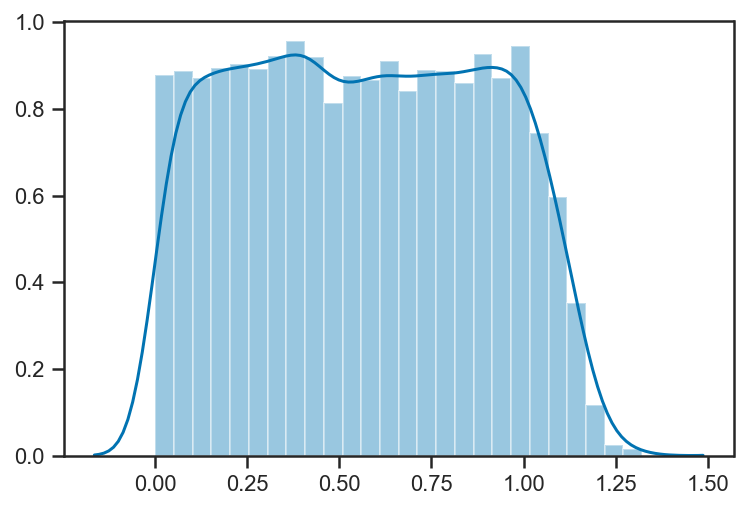

In [4]:
sns.distplot(draw(size=10000))

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


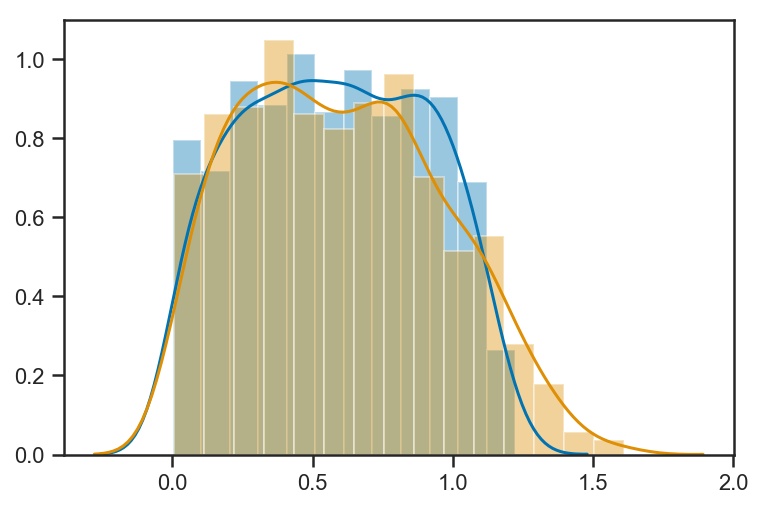

In [34]:
N = 1000

sigma_obs = 0.2

xs_true = draw(N)
xs_obs = xs_true + sigma_obs*randn(N)
s = xs_obs < 0
while count_nonzero(s) > 0:
    xs_obs[s] = xs_true[s] + sigma_obs*randn(count_nonzero(s))
    s = xs_obs < 0

sns.distplot(xs_true)
sns.distplot(xs_obs)

In [35]:
zs = (xs_obs - xs_true)/0.2

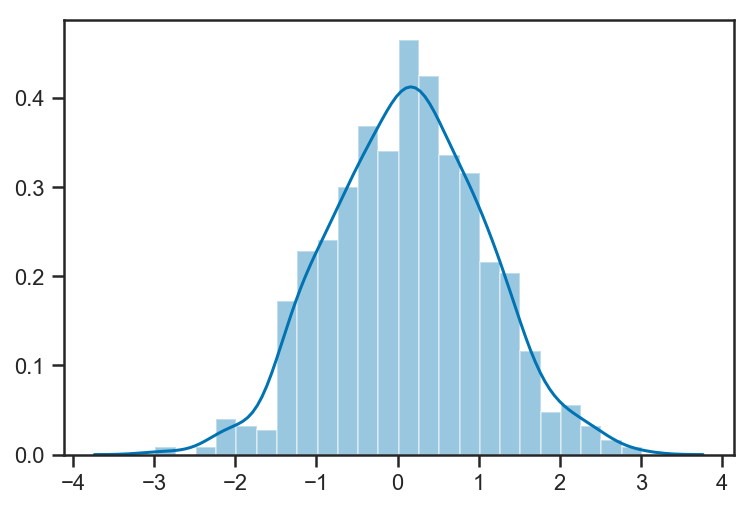

In [36]:
sns.distplot(zs)

In [37]:
Nsamp = 512
xs_samp = xs_obs[:,newaxis] + sigma_obs*randn(N, Nsamp)

In [38]:
count_nonzero((xs_true < np.min(xs_samp, axis=1)) | (xs_true > np.max(xs_samp, axis=1)))

1

In [30]:
stan_code = \
"""
functions {
  real[,] log_px(real[,] xs, real x_cut, real sigma_cutoff) {
    real flat_norm = x_cut;
    real gaus_norm = sqrt(pi()/2.0)*sigma_cutoff;
    
    real log_norm = log(x_cut + gaus_norm);
    
    real lpx[dims(xs)[1], dims(xs)[2]];
    
    real sigma_cutoff2 = sigma_cutoff*sigma_cutoff;
    
    int nobs;
    int nsamp;
    
    nobs = dims(xs)[1];
    nsamp = dims(xs)[2];
    
    for (i in 1:nobs) {
      for (j in 1:nsamp) {
        if (xs[i,j] < x_cut) {
          lpx[i,j] = -log_norm;
        } else {
          real dx = xs[i,j] - x_cut;
          lpx[i,j] = -0.5*dx*dx/sigma_cutoff2 - log_norm;
        }
      }
    }
    
    return lpx;
  }
}

data {
  int nobs;
  int nsamp;
  real xs[nobs, nsamp];
}

parameters {
  real<lower=0.5, upper=1.5> x_cut;
  real<lower=0> sigma_cutoff;
}

model {
  real lpx[nobs, nsamp];
  
  /* Flat priors on both parameters */
  
  lpx = log_px(xs, x_cut, sigma_cutoff);
  
  for (i in 1:nobs) {
    target += log_sum_exp(lpx[i,:]) - log(nsamp);
  }
}
"""

In [13]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ff81ffd4c085cd7ddf1b2aa624025bae NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp2isgsujt/stanfit4anon_model_ff81ffd4c085cd7ddf1b2aa624025bae_6205733071474714957.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [39]:
data = {
    'nobs': N,
    'nsamp': Nsamp,
    'xs': xs_samp
}

In [40]:
fit = model.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25e67710>,
      dtype=object)

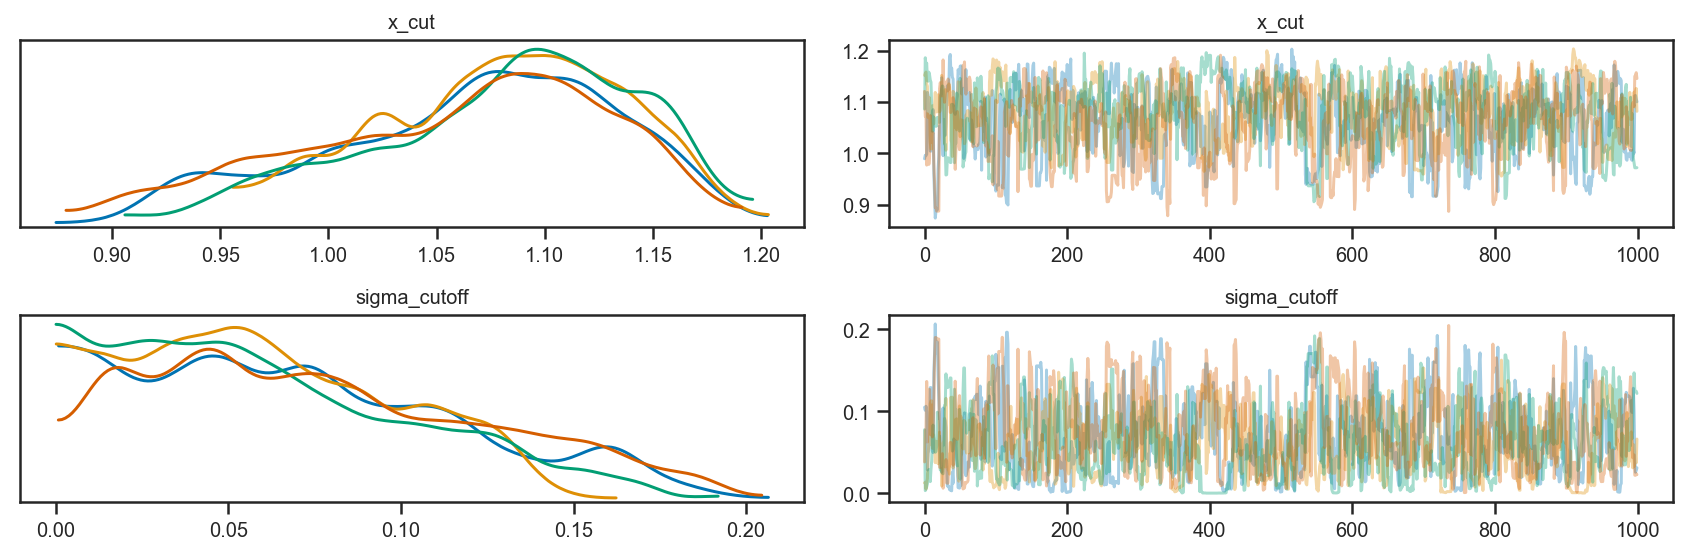

In [41]:
az.plot_trace(fit)

In [42]:
stan_resample = \
"""
functions {
  real[] log_px(real[] xs, real x_cut, real sigma_cutoff) {
    real flat_norm = x_cut;
    real gaus_norm = sqrt(pi()/2.0)*sigma_cutoff;
    
    real log_norm = log(x_cut + gaus_norm);
    
    int nobs = size(xs);
    
    real lpx[nobs];
    
    real sigma_cutoff2 = sigma_cutoff*sigma_cutoff;
    
    for (i in 1:nobs) {
      if (xs[i] < x_cut) {
        lpx[i] = -log_norm;
      } else {
        real dx = xs[i] - x_cut;
        lpx[i] = -0.5*dx*dx/sigma_cutoff2 - log_norm;
      }
    }

    return lpx;
  }
}

data {
  int nobs;
  real xs_obs[nobs];
  real sigma_obs;
}

parameters {
  real<lower=0.5, upper=1.5> x_cut;
  real<lower=0> sigma_cutoff;
  
  real<lower=0> xs[nobs];
}

model {
  real lpx[nobs];
  
  /* Flat priors on both parameters */
  
  lpx = log_px(xs, x_cut, sigma_cutoff);
  target += sum(lpx);
  
  for (i in 1:nobs) {
    xs_obs[i] ~ normal(xs[i], sigma_obs) T[0,];
  }
}
"""

In [43]:
model_resample = pystan.StanModel(model_code=stan_resample)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95839b5faf28c442f99f0d20e02ae73c NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp94migqjc/stanfit4anon_model_95839b5faf28c442f99f0d20e02ae73c_8945077350633384419.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [44]:
data_resample = {
    'nobs': N,
    'xs_obs': xs_obs,
    'sigma_obs': sigma_obs
}

In [46]:
fit_resample = model_resample.sampling(data=data_resample)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c443dcb38>,
      dtype=object)

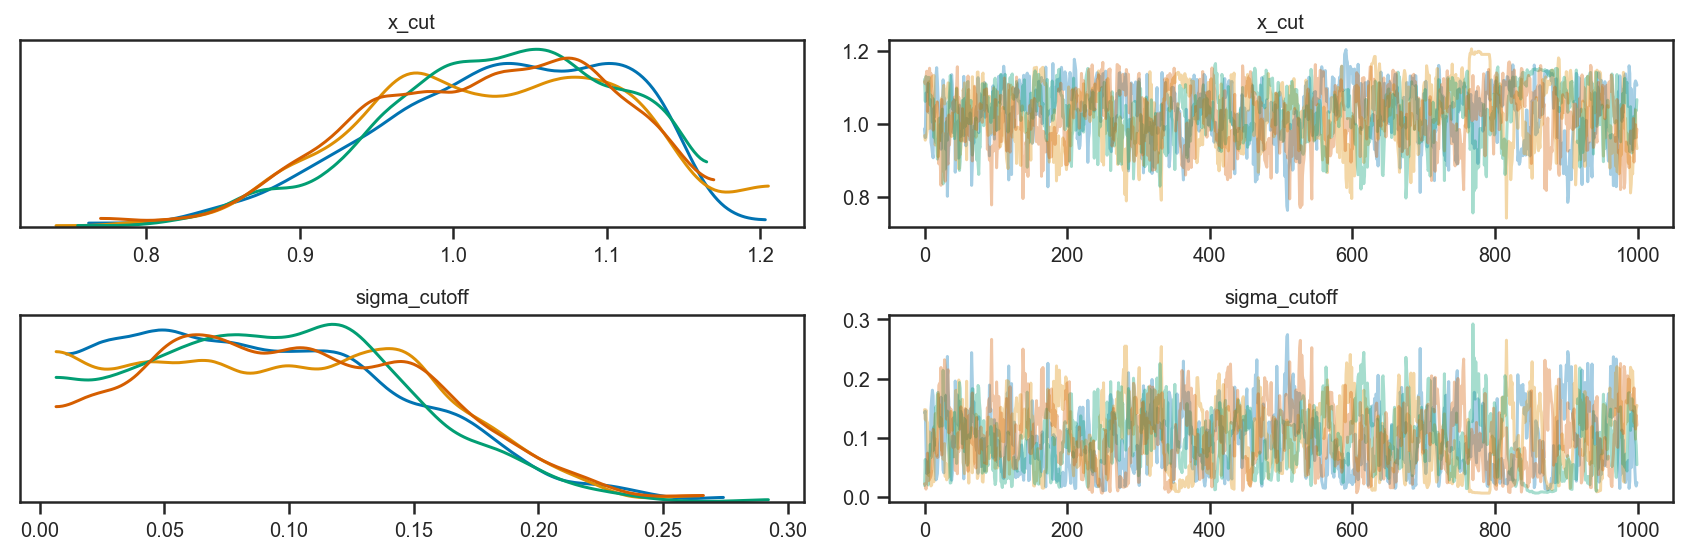

In [48]:
az.plot_trace(fit_resample, var_names=['x_cut', 'sigma_cutoff'])